In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from Common import NeuralNet
import time

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [2]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_, alpha_f_=0.005, h_f_=5, T_hot_=4, T_0_=1, U_f_=None):
        self.n_int = n_int_     # n_int_:= number of intertior points
        self.n_sb = n_sb_       # n_sb_ := number of spatial boundary points
        self.n_tb = n_tb_       # n_tb_ := number of time boundary points

        # Set the paremeters of the equation
        self.alpha_f = alpha_f_
        self.h_f = h_f_
        self.T_hot = T_hot_
        self.T_0 = T_0_
        self.U_f = U_f_

        # Extrema of the solution domain (t,x) in [0, t]x[0, L]
        self.domain_extrema = torch.tensor([[0, 8],  # Time dimension
                                            [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # FF Dense NN to approximate the solution of the underlying reaction-convection-diffusion equations of the fluid
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1, # is a NN with input_dim=2 (time & space), output_dim=1 (fluid_temp)
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)
        
        # FF Dense NN to approximate the solid temperature we wish to infer
        self.approximate_coefficient = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,  # is a NN with input_dim=2 (time & space), output_dim=1 (solid_temp)
                                                 n_hidden_layers=4,
                                                 neurons=20,
                                                 regularization_param=0.,
                                                 regularization_exp=2.,
                                                 retrain_seed=42)

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])   # it will create a 2 cloumns tensor, the rows nunmber is specified after every time it is used

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int, self.training_set_meas = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]
    
    # Function Uf(t) -> given the time it gives back the velocity of the fluid in the relative phase
    def fluid_velocity(self, inputs):
        Uf = torch.full(inputs.shape, 999)  # give all 999 for semplicity when testing
        
        # """QUI"""
        # print("\nfluid_velocity")
        # print('inputs: ', inputs.shape)

        for i, t in enumerate(inputs):
            # Charging Phase
            if (t <= 1) or (t > 4 and t <=5 ): Uf[i] = 1
            # Discharging Phase
            elif (t > 2 and t <= 3) or (t > 6 and t <= 7): Uf[i] = -1
            # Idle Phase
            elif (t > 1 and t <= 2) or (t > 3 and t <= 4) or (t > 5 and t <= 6) or (t > 7 and t <= 8): Uf[i] = 0

        return Uf
    
    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.soboleng.draw(self.n_tb)    # input_sb has two columns (t, x) both with random numbers in the two respective domains
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)   # overwrite the entier column of time with t0
        output_tb = torch.full(input_tb[:, 0].shape, self.T_0).reshape(-1, 1)   # the output has 1 column

        # """QUI"""
        # print('ADD TEMPORAL BOUDARY POINTS:')
        # print('input_tb: ', input_tb.shape)
        # print('output_tb: ', output_tb.shape)

        return input_tb, output_tb  # input_tb is the sequence of x_n; output_tb is the sequence u0(x_n)

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        # Dataset with random [t, x] both in [0, 1]
        input_sb = self.soboleng.draw(self.n_sb)

        # Assigne the spacial boundary x=x0
        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        # Assigne the spacial boundary x=xL
        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        # Def a tensor to add the delta in time to each of the input dataset and have the different phases
        # This tenosr is full of [0, 0] and it will be filled on the t-column with the relative delta_t
        delta_time = torch.zeros_like(input_sb)

        # We are going now to define the input dataset for all the different phases over the 2 cycles.
        # However, not that even if the input for the same phase over the 2 cycles is different (the t)
        # the output is always the same (the spatial boundary conditions are the same), so we just need one output per phase.
        """Charging Phase"""
        # First charging phase -> t in [0, 1] => delta_t=0
        input_sb_0_charging_1 = torch.clone(input_sb_0)
        input_sb_L_charging_1 = torch.clone(input_sb_L)
        
        # Second charging phase -> t in [4, 5] => delta_t=4
        delta_time[:, 0] = torch.full(delta_time[:, 0].shape, 4)

        input_sb_0_charging_2 = torch.clone(input_sb_0)
        input_sb_0_charging_2 = input_sb_0_charging_2 + delta_time

        input_sb_L_charging_2 = torch.clone(input_sb_L)
        input_sb_L_charging_2 = input_sb_L_charging_2 + delta_time

        # Output charging phase
        output_sb_0_charging = torch.full(input_sb_0[:, 0].shape, self.T_hot).reshape(-1, 1)
        output_sb_L_charging = torch.full(input_sb_L[:, 0].shape, 0).reshape(-1, 1)

        """Discharging Phase"""
        # First discharging phase -> t in [2, 3] => delta_t=2
        delta_time[:, 0] = torch.full(delta_time[:, 0].shape, 2)

        input_sb_0_discharging_1 = torch.clone(input_sb_0)
        input_sb_0_discharging_1 = input_sb_0_discharging_1 + delta_time

        input_sb_L_discharging_1 = torch.clone(input_sb_L)
        input_sb_L_discharging_1 = input_sb_L_discharging_1 + delta_time

        # Second discharging phase -> t in [6, 7] => delta_t=6
        delta_time[:, 0] = torch.full(delta_time[:, 0].shape, 6)

        input_sb_0_discharging_2 = torch.clone(input_sb_0)
        input_sb_0_discharging_2 = input_sb_0_discharging_2 + delta_time

        input_sb_L_discharging_2 = torch.clone(input_sb_L)
        input_sb_L_discharging_2 = input_sb_L_discharging_2 + delta_time

        # Output discharging phase
        output_sb_0_discharging = torch.full(input_sb_0[:, 0].shape, 0).reshape(-1, 1)
        output_sb_L_discharging = torch.full(input_sb_L[:, 0].shape, self.T_0).reshape(-1, 1)


        """Idle Phase"""
        # First idle phase -> t in [1, 2] => delta_t=1
        delta_time[:, 0] = torch.full(delta_time[:, 0].shape, 1)

        input_sb_0_idle_1 = torch.clone(input_sb_0)
        input_sb_0_idle_1 = input_sb_0_idle_1 + delta_time

        input_sb_L_idle_1 = torch.clone(input_sb_L)
        input_sb_L_idle_1 = input_sb_L_idle_1 + delta_time

        # Second idle phase -> t in [3, 4] => delta_t=3
        delta_time[:, 0] = torch.full(delta_time[:, 0].shape, 3)

        input_sb_0_idle_2 = torch.clone(input_sb_0)
        input_sb_0_idle_2 = input_sb_0_idle_2 + delta_time

        input_sb_L_idle_2 = torch.clone(input_sb_L)
        input_sb_L_idle_2 = input_sb_L_idle_2 + delta_time

        # Third idle phase -> t in [5, 6] => delta_t=5
        delta_time[:, 0] = torch.full(delta_time[:, 0].shape, 5)

        input_sb_0_idle_3 = torch.clone(input_sb_0)
        input_sb_0_idle_3 = input_sb_0_idle_3 + delta_time

        input_sb_L_idle_3 = torch.clone(input_sb_L)
        input_sb_L_idle_3 = input_sb_L_idle_3 + delta_time

        # Fourth idle phase -> t in [7, 8] => delta_t=7
        delta_time[:, 0] = torch.full(delta_time[:, 0].shape, 7)

        input_sb_0_idle_4 = torch.clone(input_sb_0)
        input_sb_0_idle_4 = input_sb_0_idle_4 + delta_time

        input_sb_L_idle_4 = torch.clone(input_sb_L)
        input_sb_L_idle_4 = input_sb_L_idle_4 + delta_time

        # Output idle phase
        output_sb_0_idle = torch.full(input_sb_0[:, 0].shape, 0).reshape(-1, 1)
        output_sb_L_idle = torch.full(input_sb_L[:, 0].shape, 0).reshape(-1, 1)

        # """QUI"""
        # print('CYCLE 1:')
        # print('input_sb_0_charging_1: ', input_sb_0_charging_1.shape)
        # print('input_sb_L_charging_1: ', input_sb_L_charging_1.shape)
        # print('input_sb_0_idle_1: ', input_sb_0_idle_1.shape)
        # print('input_sb_L_idle_1: ', input_sb_L_idle_1.shape)
        # print('input_sb_0_discharging_1: ', input_sb_0_discharging_1.shape)
        # print('input_sb_L_discharging_1: ', input_sb_L_discharging_1.shape)
        # print('input_sb_0_idle_2: ', input_sb_0_idle_2.shape)
        # print('input_sb_L_idle_2: ', input_sb_L_idle_2.shape)
        # print('\nCYCLE 2:')
        # print('input_sb_0_charging_2: ', input_sb_0_charging_2.shape)
        # print('input_sb_L_charging_2: ', input_sb_L_charging_2.shape)
        # print('input_sb_0_idle_3: ', input_sb_0_idle_3.shape)
        # print('input_sb_L_idle_3: ', input_sb_L_idle_3.shape)
        # print('input_sb_0_discharging_2: ', input_sb_0_discharging_2.shape)
        # print('input_sb_L_discharging_2: ', input_sb_L_discharging_2.shape)
        # print('input_sb_0_idle_4: ', input_sb_0_idle_4.shape)
        # print('input_sb_L_idle_4: ', input_sb_L_idle_4.shape)
        # print('\nOUTPUT:')
        # print('output_sb_0_charging: ', output_sb_0_charging.shape)
        # print('output_sb_L_charging: ', output_sb_L_charging.shape)
        # print('output_sb_0_idle: ', output_sb_0_idle.shape)
        # print('output_sb_L_idle: ', output_sb_L_idle.shape)
        # print('output_sb_0_discharging: ', output_sb_0_discharging.shape)
        # print('output_sb_L_discharging: ', output_sb_L_discharging.shape)
        
        # requires the grad for input tensors as we will have to compute the derivatives
        return torch.cat([  # cycle 1
                        input_sb_0_charging_1.requires_grad_(True), input_sb_L_charging_1.requires_grad_(True),
                        input_sb_0_idle_1.requires_grad_(True), input_sb_L_idle_1.requires_grad_(True),
                        input_sb_0_discharging_1.requires_grad_(True), input_sb_L_discharging_1.requires_grad_(True),
                        input_sb_0_idle_2.requires_grad_(True), input_sb_L_idle_2.requires_grad_(True),
                            # cycle 2
                        input_sb_0_charging_2.requires_grad_(True), input_sb_L_charging_2.requires_grad_(True),
                        input_sb_0_idle_3.requires_grad_(True), input_sb_L_idle_3.requires_grad_(True),
                        input_sb_0_discharging_2.requires_grad_(True), input_sb_L_discharging_2.requires_grad_(True),
                        input_sb_0_idle_4.requires_grad_(True), input_sb_L_idle_4.requires_grad_(True)
                        ], 0), torch.cat([  # cycle 1
                                        output_sb_0_charging, output_sb_L_charging,
                                        output_sb_0_idle, output_sb_L_idle,
                                        output_sb_0_discharging, output_sb_L_discharging,
                                        output_sb_0_idle, output_sb_L_idle,
                                            # cycle 2
                                        output_sb_0_charging, output_sb_L_charging,
                                        output_sb_0_idle, output_sb_L_idle,
                                        output_sb_0_discharging, output_sb_L_discharging,
                                        output_sb_0_idle, output_sb_L_idle
                                        ], 0)

    # Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        # Now we use the convert fct since we want the t is in [0, 8]
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        
        return input_int, output_int
    
    # Function returning the input-output tensor required to assemble the training set S_meas corresponding to the measured points in the domain.
    # These points are read from the file "DataSolution.txt"
    def get_measurement_data(self):
        # Read the CSV file into a DataFrame
        df_meas = pd.read_csv('DataSolution.txt')

        # Convert the DataFrame to a torch.tensor
        tensor_meas = torch.tensor(df_meas.values , dtype=torch.float)
        
        # The first 2 columns are the inputs: [t, x]
        input_meas = tensor_meas[:, :2]
        
        # The last column are the outputs: [Tf]
        output_meas = tensor_meas[:, 2:]
        return input_meas, output_meas

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()    # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()   # S_tb
        input_int, output_int = self.add_interior_points()          # S_int
        input_meas, output_meas = self.get_measurement_data()       # S_meas

        # """QUI"""
        # print('\nSONO IN assemble_datasets:')
        # print('input_sb', input_sb.shape)
        # print('output_sb', output_sb.shape)
        # print()
        # print('input_tb', input_tb.shape)
        # print('output_tb', output_tb.shape)
        # print()
        # print('input_int', input_int.shape)
        # print('output_int', output_int.shape)
        # print()
        # print('input_meas', input_meas.shape)
        # print('output_meas', output_meas.shape)
        # print()

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=16*self.space_dimensions*self.n_sb, shuffle=False)  #batch_size has *8 since there are 8 different phases and for each one we have 2 conditions (x0 & xL)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)
        training_set_meas = DataLoader(torch.utils.data.TensorDataset(input_meas, output_meas), batch_size=output_meas.shape[0], shuffle=False)

        return training_set_sb, training_set_tb, training_set_int, training_set_meas

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        # input_tb is a tensor of size [16*self.n_sb, 2]
        # as defined in "add_spatial_boundary_points" we have 2 boundary conditions for each phase
        # we then have to devide the input_sb in 16
        assert (input_sb.requires_grad==True)   # make sure the grad is requested so we can compute the derivatives

        # Devide all the input datasets
            # cycle 1
        input_sb_0_charging_1 = input_sb[:int(input_sb.shape[0]/16), :]
        input_sb_L_charging_1 = input_sb[int(input_sb.shape[0]/16):2*int(input_sb.shape[0]/16), :]
        input_sb_0_idle_1 = input_sb[2*int(input_sb.shape[0]/16):3*int(input_sb.shape[0]/16), :]
        input_sb_L_idle_1 = input_sb[3*int(input_sb.shape[0]/16):4*int(input_sb.shape[0]/16), :]
        input_sb_0_discharging_1 = input_sb[4*int(input_sb.shape[0]/16):5*int(input_sb.shape[0]/16), :]
        input_sb_L_discharging_1 = input_sb[5*int(input_sb.shape[0]/16):6*int(input_sb.shape[0]/16), :]
        input_sb_0_idle_2 = input_sb[6*int(input_sb.shape[0]/16):7*int(input_sb.shape[0]/16), :]
        input_sb_L_idle_2 = input_sb[7*int(input_sb.shape[0]/16):8*int(input_sb.shape[0]/16), :]
            # cycle 2
        input_sb_0_charging_2 = input_sb[8*int(input_sb.shape[0]/16):9*int(input_sb.shape[0]/16), :]
        input_sb_L_charging_2 = input_sb[9*int(input_sb.shape[0]/16):10*int(input_sb.shape[0]/16), :]
        input_sb_0_idle_3 = input_sb[10*int(input_sb.shape[0]/16):11*int(input_sb.shape[0]/16), :]
        input_sb_L_idle_3 = input_sb[11*int(input_sb.shape[0]/16):12*int(input_sb.shape[0]/16), :]
        input_sb_0_discharging_2 = input_sb[12*int(input_sb.shape[0]/16):13*int(input_sb.shape[0]/16), :]
        input_sb_L_discharging_2 = input_sb[13*int(input_sb.shape[0]/16):14*int(input_sb.shape[0]/16), :]
        input_sb_0_idle_4 = input_sb[14*int(input_sb.shape[0]/16):15*int(input_sb.shape[0]/16), :]
        input_sb_L_idle_4 = input_sb[15*int(input_sb.shape[0]/16):, :]

        """Charging Phase"""
        # First charging phase
            # x0 -> compute Tf
        u_pred_sb_0_charging_1 = self.approximate_solution(input_sb_0_charging_1).reshape(-1, 1)

            # xL -> compute dTf/dx
        u_pred_Tf = self.approximate_solution(input_sb_L_charging_1)
        u_pred_sb_L_charging_1 = torch.autograd.grad(u_pred_Tf.sum(), input_sb_L_charging_1, create_graph=True)[0][:, 1].reshape(-1, 1) # take only d/dx

        # Second charging phase
            # x0 -> compute Tf
        u_pred_sb_0_charging_2 = self.approximate_solution(input_sb_0_charging_2).reshape(-1, 1)

            # xL -> compute dTf/dx
        u_pred_Tf = self.approximate_solution(input_sb_L_charging_2)
        u_pred_sb_L_charging_2 = torch.autograd.grad(u_pred_Tf.sum(), input_sb_L_charging_2, create_graph=True)[0][:, 1].reshape(-1, 1) # take only d/dx

        """Discharging Phase"""
        # First discharging phase
            # x0 -> compute dTf/dx
        u_pred_Tf = self.approximate_solution(input_sb_0_discharging_1)
        u_pred_sb_0_discharging_1 = torch.autograd.grad(u_pred_Tf.sum(), input_sb_0_discharging_1, create_graph=True)[0][:, 1].reshape(-1, 1) # take only d/dx
        
            # xL -> compute Tf
        u_pred_sb_L_discharging_1 = self.approximate_solution(input_sb_L_discharging_1).reshape(-1, 1)

        # Second discharging phase
            # x0 -> compute dTf/dx
        u_pred_Tf = self.approximate_solution(input_sb_0_discharging_2)
        u_pred_sb_0_discharging_2 = torch.autograd.grad(u_pred_Tf.sum(), input_sb_0_discharging_2, create_graph=True)[0][:, 1].reshape(-1, 1) # take only d/dx
        
            # xL -> compute Tf
        u_pred_sb_L_discharging_2 = self.approximate_solution(input_sb_L_discharging_2).reshape(-1, 1)

        """Idle Phase"""
        # First idle phase
            # x0 -> compute dTf/dx
        u_pred_Tf = self.approximate_solution(input_sb_0_idle_1)
        u_pred_sb_0_idle_1 = torch.autograd.grad(u_pred_Tf.sum(), input_sb_0_idle_1, create_graph=True)[0][:, 1].reshape(-1, 1) # take only d/dx

            # xL -> compute dTf/dx
        u_pred_Tf = self.approximate_solution(input_sb_L_idle_1)
        u_pred_sb_L_idle_1 = torch.autograd.grad(u_pred_Tf.sum(), input_sb_L_idle_1, create_graph=True)[0][:, 1].reshape(-1, 1) # take only d/dx

        # Second idle phase
            # x0 -> compute dTf/dx
        u_pred_Tf = self.approximate_solution(input_sb_0_idle_2)
        u_pred_sb_0_idle_2 = torch.autograd.grad(u_pred_Tf.sum(), input_sb_0_idle_2, create_graph=True)[0][:, 1].reshape(-1, 1) # take only d/dx

            # xL -> compute dTf/dx
        u_pred_Tf = self.approximate_solution(input_sb_L_idle_2)
        u_pred_sb_L_idle_2 = torch.autograd.grad(u_pred_Tf.sum(), input_sb_L_idle_2, create_graph=True)[0][:, 1].reshape(-1, 1) # take only d/dx

        # Third idle phase
            # x0 -> compute dTf/dx
        u_pred_Tf = self.approximate_solution(input_sb_0_idle_3)
        u_pred_sb_0_idle_3 = torch.autograd.grad(u_pred_Tf.sum(), input_sb_0_idle_3, create_graph=True)[0][:, 1].reshape(-1, 1) # take only d/dx

            # xL -> compute dTf/dx
        u_pred_Tf = self.approximate_solution(input_sb_L_idle_3)
        u_pred_sb_L_idle_3 = torch.autograd.grad(u_pred_Tf.sum(), input_sb_L_idle_3, create_graph=True)[0][:, 1].reshape(-1, 1) # take only d/dx

        # Fourth idle phase
            # x0 -> compute dTf/dx
        u_pred_Tf = self.approximate_solution(input_sb_0_idle_4)
        u_pred_sb_0_idle_4 = torch.autograd.grad(u_pred_Tf.sum(), input_sb_0_idle_4, create_graph=True)[0][:, 1].reshape(-1, 1) # take only d/dx

            # xL -> compute dTf/dx
        u_pred_Tf = self.approximate_solution(input_sb_L_idle_4)
        u_pred_sb_L_idle_4 = torch.autograd.grad(u_pred_Tf.sum(), input_sb_L_idle_4, create_graph=True)[0][:, 1].reshape(-1, 1) # take only d/dx
        
        # """QUI"""
        # print('CYCLE 1:')
        # print('u_pred_sb_0_charging_1: ', u_pred_sb_0_charging_1.shape)
        # print('u_pred_sb_L_charging_1: ', u_pred_sb_L_charging_1.shape)
        # print('u_pred_sb_0_idle_1: ', u_pred_sb_0_idle_1.shape)
        # print('u_pred_sb_L_idle_1: ', u_pred_sb_L_idle_1.shape)
        # print('u_pred_sb_0_discharging_1: ', u_pred_sb_0_discharging_1.shape)
        # print('u_pred_sb_L_discharging_1: ', u_pred_sb_L_discharging_1.shape)
        # print('u_pred_sb_0_idle_2: ', u_pred_sb_0_idle_2.shape)
        # print('u_pred_sb_L_idle_2: ', u_pred_sb_L_idle_2.shape)
        # print('\nCYCLE 2:')
        # print('u_pred_sb_0_charging_2: ', u_pred_sb_0_charging_2.shape)
        # print('u_pred_sb_L_charging_2: ', u_pred_sb_L_charging_2.shape)
        # print('u_pred_sb_0_idle_3: ', u_pred_sb_0_idle_3.shape)
        # print('u_pred_sb_L_idle_3: ', u_pred_sb_L_idle_3.shape)
        # print('u_pred_sb_0_discharging_2: ', u_pred_sb_0_discharging_2.shape)
        # print('u_pred_sb_L_discharging_2: ', u_pred_sb_L_discharging_2.shape)
        # print('u_pred_sb_0_idle_4: ', u_pred_sb_0_idle_4.shape)
        # print('u_pred_sb_L_idle_4: ', u_pred_sb_L_idle_4.shape)

        return torch.cat([  # cycle 1
                        u_pred_sb_0_charging_1, u_pred_sb_L_charging_1,
                        u_pred_sb_0_idle_1, u_pred_sb_L_idle_1,
                        u_pred_sb_0_discharging_1, u_pred_sb_L_discharging_1,
                        u_pred_sb_0_idle_2, u_pred_sb_L_idle_2,
                            # cycle 2
                        u_pred_sb_0_charging_2, u_pred_sb_L_charging_2,
                        u_pred_sb_0_idle_3, u_pred_sb_L_idle_3,
                        u_pred_sb_0_discharging_2, u_pred_sb_L_discharging_2,
                        u_pred_sb_0_idle_4, u_pred_sb_L_idle_4
                        ], 0)

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int).reshape(-1,)       # u is the solution (Tf) of the PDE
        g = self.approximate_coefficient(input_int).reshape(-1,)    # g is the function (Ts) that is requested

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 + u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 + u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi

        # Since u for us is u = (uf, us), we have to devide the two cases

        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]

        # Compute the velocity of the fluid Uf(t)
        Uf = self.fluid_velocity(input_int[:, 0])

        residual = (grad_u_t + Uf*grad_u_x) - (self.alpha_f*grad_u_xx - self.h_f*(u-g))

        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, inp_train_meas, u_train_meas, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)
        u_pred_meas = self.approximate_solution(inp_train_meas)

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])
        assert (u_pred_meas.shape[1] == u_train_meas.shape[1])


        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb
        r_meas = u_train_meas - u_pred_meas

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)
        loss_meas = torch.mean(abs(r_meas) ** 2)

        loss_u = loss_sb + loss_tb + loss_meas

        loss = torch.log10(self.lambda_u * loss_u + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_int).item(), 4), "| Function Loss: ", round(torch.log10(loss_u).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int), (inp_train_meas, u_train_meas)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int, self.training_set_meas)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, inp_train_meas, u_train_meas, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss
                
                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)

        output = self.approximate_solution(inputs).reshape(-1, )
        exact_output = self.exact_solution(inputs).reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=exact_output.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Exact Solution")
        axs[1].set_title("Approximate Solution")

        plt.show()

        err = (torch.mean((output - exact_output) ** 2) / torch.mean(exact_output ** 2)) ** 0.5 * 100
        print("L2 Relative Error Norm: ", err.item(), "%")


In [3]:
n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

## Test the functions

### Uf(t): fluid velocity

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


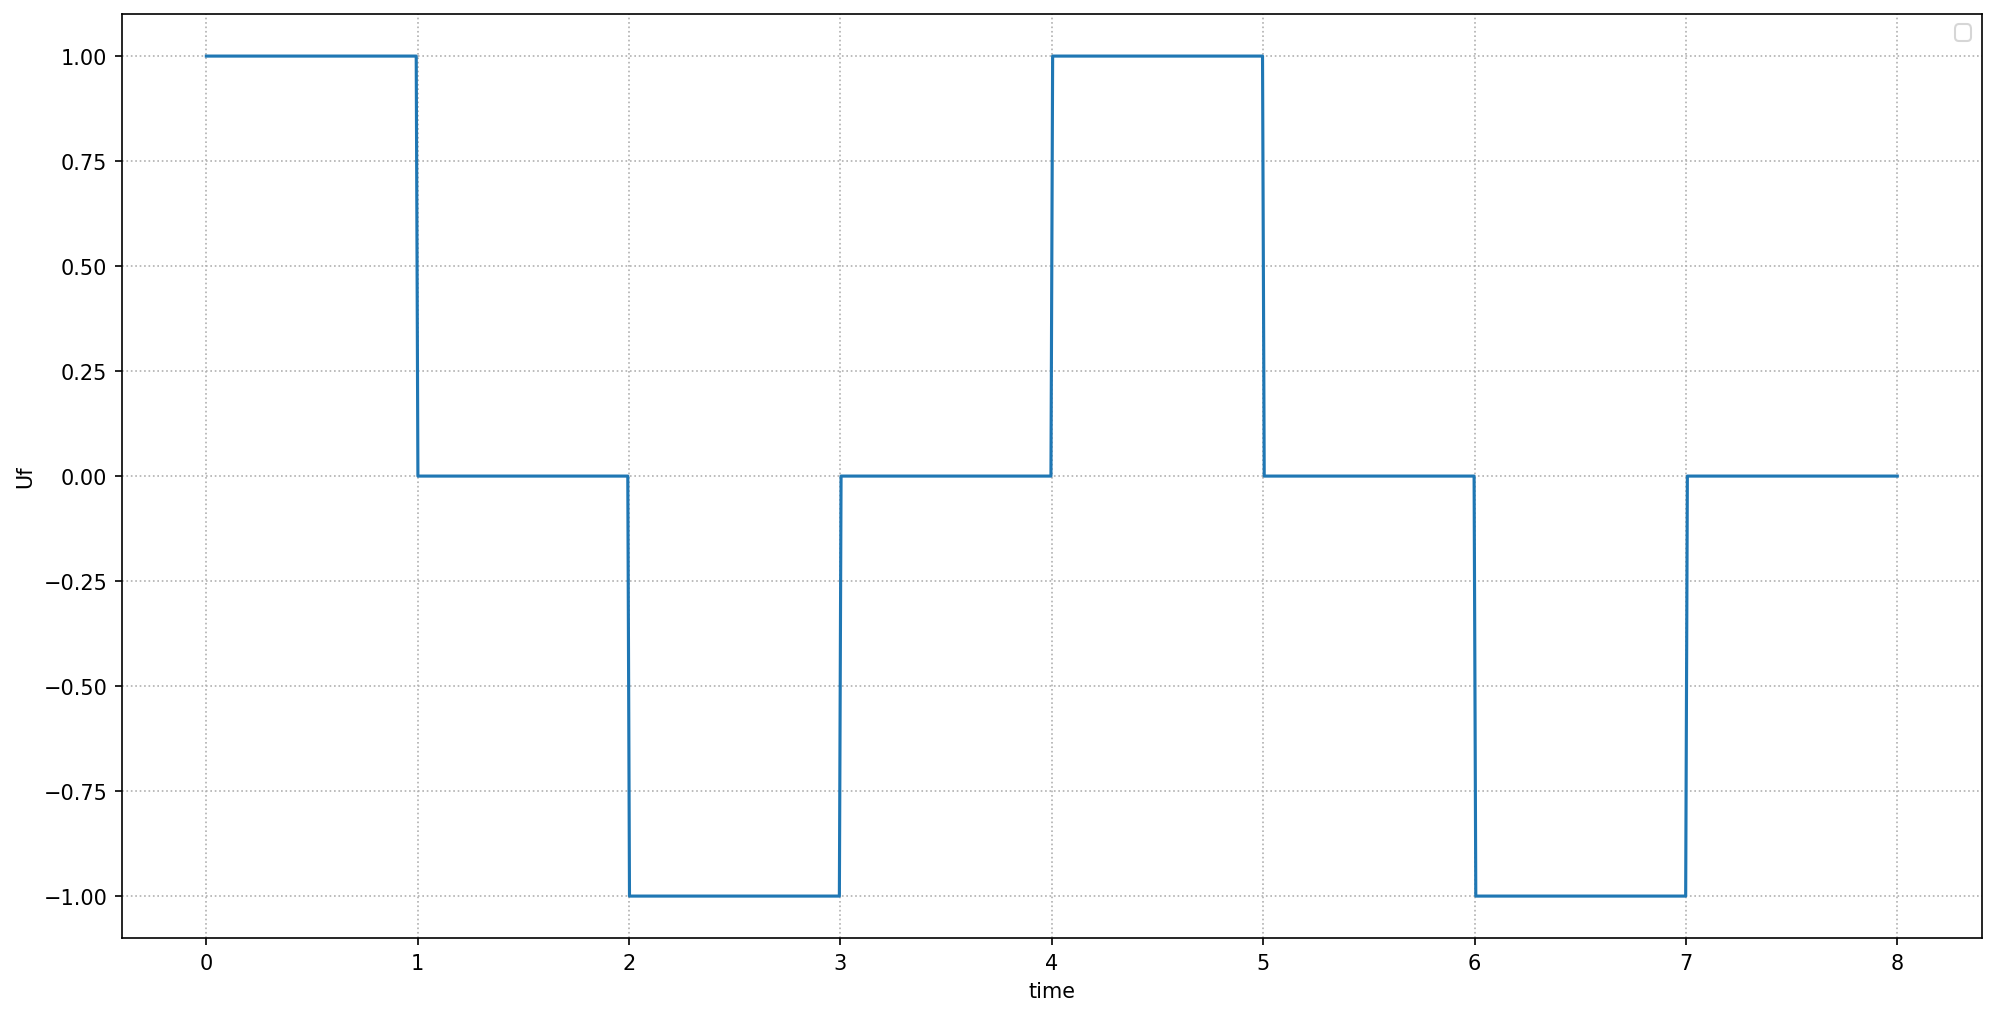

In [4]:
# Generate some points for the time in [0, 8]
input_time = torch.linspace(0, 8, 1000, dtype=torch.float).reshape(-1, 1)

Uf = pinn.fluid_velocity(input_time)

plt.figure(figsize=(16, 8), dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(input_time.detach().numpy(), Uf.detach().numpy())
plt.xlabel("time")
plt.ylabel("Uf")
plt.legend()
plt.show()

## Train

In [4]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(list(pinn.approximate_solution.parameters()) + list(pinn.approximate_coefficient.parameters()),
                              lr=float(0.5),
                              max_iter=1000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)

################################  0  ################################
Total loss:  1.6793 | PDE Loss:  -0.3163 | Function Loss:  0.6749
Total loss:  1.6182 | PDE Loss:  -0.0215 | Function Loss:  0.6081
Total loss:  1.4394 | PDE Loss:  0.7502 | Function Loss:  0.34
Total loss:  1.3976 | PDE Loss:  0.6363 | Function Loss:  0.315
Total loss:  1.1993 | PDE Loss:  -0.1245 | Function Loss:  0.1782
Total loss:  1.1151 | PDE Loss:  -0.3023 | Function Loss:  0.0982
Total loss:  1.1094 | PDE Loss:  -0.3855 | Function Loss:  0.0953
Total loss:  1.1066 | PDE Loss:  -0.4141 | Function Loss:  0.0933
Total loss:  1.1004 | PDE Loss:  -0.4488 | Function Loss:  0.088
Total loss:  1.0932 | PDE Loss:  -0.5054 | Function Loss:  0.0821
Total loss:  1.0854 | PDE Loss:  -0.5107 | Function Loss:  0.0742
Total loss:  1.0751 | PDE Loss:  -0.5345 | Function Loss:  0.0643
Total loss:  1.0678 | PDE Loss:  -0.5401 | Function Loss:  0.057
Total loss:  1.0625 | PDE Loss:  -0.5671 | Function Loss:  0.0522
Total loss:  

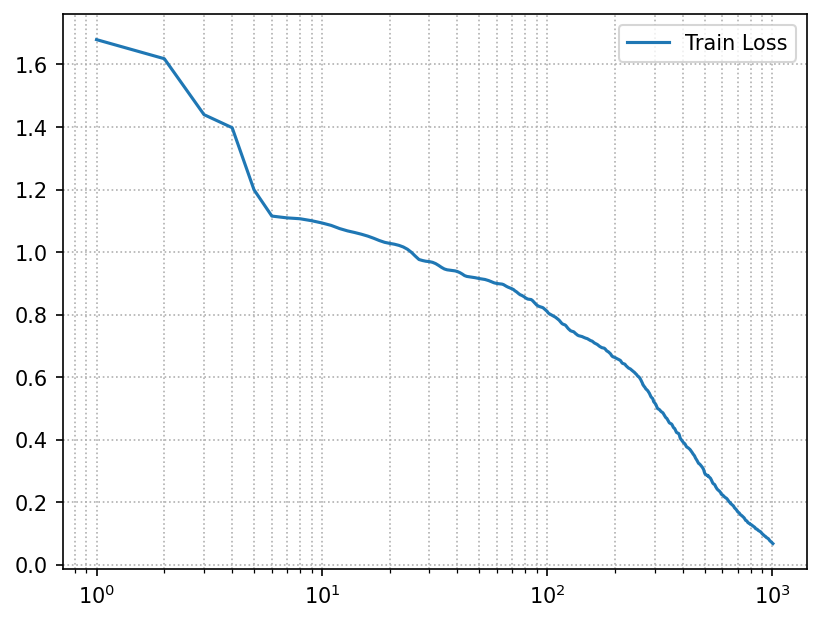

In [5]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

In [ ]:
t = 1
x = 0
# inputs [t, x]
inputs = torch.tensor([t, x], dtype=torch.float, requires_grad=True)
output = pinn.approximate_solution(inputs).reshape(-1, )

print("inputs: ", inputs)
print("output: ", output)

In [ ]:
Tf = output[0]
Ts = output[1]
t = inputs[0]
x = inputs[1]
dTf_dx = torch.autograd.grad(Ts, inputs, create_graph=True)[0][1]
dTf_dx

### Check Boundary conditions

Here we are going to evaluate the pinn output at the points where we have the boundary conditions and we will verify manually thet they correspond to the correct one.

#### Charing Phase

In [ ]:
x0 = pinn.domain_extrema[1, 0]
xL = pinn.domain_extrema[1, 1]

input_sb = pinn.soboleng.draw(10)
input_sb.requires_grad_()

In [ ]:
# input_sb = pinn.soboleng.draw(10)
# input_sb.requires_grad_()

# # T=0
# x0_t0 = pinn.domain_extrema[0, 0]
# xL_t0 = pinn.domain_extrema[0, 1]

# input_sb_0_t0 = torch.clone(input_sb)
# input_sb_0_t0[:, 1] = torch.full(input_sb_0_t0[:, 1].shape, x0_t0)

# input_sb_L_t0 = torch.clone(input_sb)
# input_sb_L_t0[:, 1] = torch.full(input_sb_L_t0[:, 1].shape, xL_t0)

# # T=1
# x0_t1 = pinn.domain_extrema[1, 0]
# xL_t1 = pinn.domain_extrema[1, 1]

# input_sb_0_t1 = torch.clone(input_sb)
# input_sb_0_t1[:, 1] = torch.full(input_sb_0_t1[:, 1].shape, x0_t1)

# input_sb_L_t1 = torch.clone(input_sb)
# input_sb_L_t1[:, 1] = torch.full(input_sb_L_t1[:, 1].shape, xL_t1)

In [ ]:
x0 = pinn.domain_extrema[1, 0]
xL = pinn.domain_extrema[1, 1]

input_sb = pinn.soboleng.draw(10)
input_sb.requires_grad_()

input_sb_0 = torch.clone(input_sb)
input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

input_sb_L = torch.clone(input_sb)
input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

print("input_sb_0: \n", input_sb_0)
print()
print("input_sb_L: \n", input_sb_L)

print()
print("----------------------------------------------")
print()

T_0 = pinn.approximate_solution(input_sb_0)
Tf_0 = T_0[:,0]
Ts_0 = T_0[:,1]
dTs_0_dx = torch.autograd.grad(Ts_0.sum(), input_sb_0, create_graph=True)[0][:, 1]

T_L = pinn.approximate_solution(input_sb_L)
Tf_L = T_L[:,0]
Ts_L = T_L[:,1]

dTf_L_dx = torch.autograd.grad(Tf_L.sum(), input_sb_L, create_graph=True)[0][:, 1]
dTs_L_dx = torch.autograd.grad(Ts_L.sum(), input_sb_L, create_graph=True)[0][:, 1]

print("dTs_0_dx: \n", dTs_0_dx.reshape(-1,1))
print()
print("dTf_L_dx: \n", dTf_L_dx.reshape(-1,1))
print()
print("dTs_L_dx: \n", dTs_L_dx.reshape(-1,1))



# output_sb_0 = ((pinn.T_hot-pinn.T_0)/(1+torch.exp(-200*(input_sb-0.25)))+pinn.T_0)  # is a tensor with two columns [T_f, T_s], however we will just want to use the first one
# output_sb_0
# save_expected = output_sb_0[:,0]
# save_expected

In this other block we are going to call the function that applies the boundary conditions.

Note that the output will be $ [T_f, T_s] $ and the 3 conditions are concatenated.

Finally note that the values $ 777 $ are for the vacant conditions

In [ ]:
pinn.apply_boundary_conditions(torch.cat([input_sb_0, input_sb_0, input_sb_L],0))

In [ ]:
# Print the output training_set_sb section 1--> Tf_0
for input, output in pinn.training_set_sb:
    print(output[:int(output.shape[0]/3), :].shape)
    print(output[:int(output.shape[0]/3), :])

In [ ]:
# Print the output training_set_sb section 2--> Ts_0_dx
for input, output in pinn.training_set_sb:
    print(output[int(output.shape[0]/3):int(2*output.shape[0]/3), :].shape)
    print(output[int(output.shape[0]/3):int(2*output.shape[0]/3), :])

In [ ]:
# Print the output training_set_sb section 3--> Tf/s_0_dx
for input, output in pinn.training_set_sb:
    print(output[int(2*output.shape[0]/3):, :].shape)
    print(output[int(2*output.shape[0]/3):, :])

In [ ]:
for input, output in pinn.training_set_sb:
    print(output)

In [37]:
import torch

# Create some tensors
x = torch.tensor([2.0], requires_grad=False)
y = torch.tensor([3.0], requires_grad=False)

# Define a function
z = x ** 2 + 2 * y
z.requires_grad_(True)
print('QUI ', z.requires_grad)

# Compute gradients
gradients = torch.autograd.grad(z, [x, y])

# Print the gradients
print('Gradient of z with respect to x:', gradients[0])
print('Gradient of z with respect to y:', gradients[1])
z.requires_grad

QUI  True


RuntimeError: One of the differentiated Tensors does not require grad